In [14]:
import sys
sys.path.append('/Users/kiralyb/Documents/GitHub/CogModelingRNNsTutorial/')

#@title Imports + defaults settings.
#%load_ext autoreload
#%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings
import importlib


warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

from CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial import rnn_utils

from scipy.io import loadmat

In [32]:
importlib.reload(rat_data)
folder_path = "/Users/kiralyb/Downloads/behavfiles/"
# List all files in the folder, excluding hidden files like .DS_Store
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and not f.startswith('.')]
all_params = {}

for file in files:
    
    LOCAL_PATH_TO_FILE = os.path.join(folder_path, file)
    
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(LOCAL_PATH_TO_FILE, '.')[:2], rnn_utils.DatasetRNN)
    n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
    experiment_list_train = None
    experiment_list_test = None

    # Initialize a dictionary to store parameters for each session
    session_params = {}
    num_sessions = dataset_train._xs.shape[1]



    Mdata = loadmat(LOCAL_PATH_TO_FILE)
    probs = Mdata['PROBS']
    #probs_combined = np.vstack((1 - probs[:, :],probs[:, :], )).T

    block_lengths = []

    mask_env_vol = np.zeros(probs.shape[1], dtype=bool)
    mask_env_fast = np.zeros(probs.shape[1], dtype=bool)
    mask_env_slow = np.zeros(probs.shape[1], dtype=bool)
    mask_env_meanvol = np.zeros(probs.shape[1], dtype=bool)

    for col in range(probs.shape[1]):
            valid_probs = probs[~np.isnan(probs[:, col]), col]
            changes = np.diff(valid_probs) != 0
            block_lengths = np.diff(np.where(np.concatenate(([True], changes)))[0])

            mask_env_vol[col] = np.sum(block_lengths != 60) > 0 and len(block_lengths) > 1
            mask_env_fast[col] = (np.sum(block_lengths < 60) != 0 and np.sum(block_lengths > 60) ==0) and len(block_lengths) > 1
            mask_env_slow[col] =  (np.sum(block_lengths > 60) >= np.sum(block_lengths < 60)) and (np.sum(block_lengths > 60) >= 1)
            mask_env_meanvol[col] = np.sum(block_lengths < 60) == 0 and np.sum(block_lengths > 60) == 0 and len(block_lengths) > 1

    env_volatility = np.where(mask_env_vol)[0]
    env_fast = np.where(mask_env_fast)[0]

    mask_env_var = np.any((probs != 0.9) & (probs != 0.1) & (probs != 0.0) & (~np.isnan(probs)), axis=0)
    env_extremity = np.where(mask_env_var)[0]

     # New environment: instances before both the first in env_volatility and env_extremity
    if len(env_volatility) > 0 and len(env_extremity) > 0:
        first_volatility = env_volatility[0]
        first_extremity = env_extremity[0]
        cutoff_index = max(first_volatility, first_extremity)
        if cutoff_index < 1:
            cutoff_index = 1
        env_pre = np.arange(cutoff_index)      
    else:
        env_pre = np.arange(probs.shape[1])


    # Filter out instances smaller than the cutoff_index
    env_slow = np.where(mask_env_slow)[0]
    env_slow = env_slow[env_slow >= cutoff_index]
    env_control = np.where((mask_env_meanvol & ~mask_env_var))[0]
    env_control = env_control[env_control >= cutoff_index]
    env_fast = env_fast[env_fast >= cutoff_index]
#    if env_control.size == 0 and env_pre.size > 0:
#        env_control = np.append(env_control, env_pre[-1])
#        env_pre = env_pre[:-1]
    
    mask_unpred = np.sum((probs == 0.9) | (probs == 0.1), axis =0) <= np.sum((probs != 0.9) & (probs != 0.1) & (probs != 0.0) & (~np.isnan(probs)), axis=0)
    env_unpred = np.where(mask_unpred)[0]
    env_controlb = np.where((~(mask_env_slow) & ~mask_env_fast & ~mask_unpred)) [0]
    env_controlb = env_controlb[env_controlb >= cutoff_index]

    #cutoff_index2 = max(first_volatility, first_extremity)
    env_volatility = env_volatility[env_volatility >= cutoff_index]
    env_extremity = env_extremity[env_extremity >= cutoff_index]
    env_unpred = env_unpred[env_unpred >= cutoff_index]

    decisons = Mdata['OUTPUT']
    # Create a mask to filter out -1 elements
    valid_mask = decisons[:, :, 1] != -1
    # Calculate collected rewards, omitting -1 elements
    collected_rewards = sum(decisons[:, :, 1] * valid_mask) / sum(valid_mask)#np.sum(decisons[:, :, 1] * [valid_mask], axis=0)
    likelymask = probs < 0.5
    likelysidedec = (sum(decisons[:, :, 0]*(~likelymask)*(valid_mask)) + sum((1-decisons[:, :, 0])*(likelymask)*(valid_mask))) / sum(valid_mask)

    # Store the param_matrix for the current file in the all_params dictionary
    all_params[file] = {

        'env_pretraining': env_pre,        
        'env_baseline': env_control,
        'env_volatility_controled': env_volatility,        
        'env_extremity_controled': env_extremity,

        'env_predictable': env_controlb,
        'env_slowly_changing': env_slow,
        'env_fast_changing': env_fast,
        'env_unpredictable': env_unpred,

        'collected_rewards': collected_rewards,
        'likelyside_picks': likelysidedec,
    }



In [34]:
use_gamma = False
use_tau = True
importlib.reload(rat_data)
all_RL_params = {}

for file in files:
    # Initialize the dictionary for the current file
    all_RL_params[file] = {}
    
    LOCAL_PATH_TO_FILE = os.path.join(folder_path, file)
    
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(LOCAL_PATH_TO_FILE, '.')[:2], rnn_utils.DatasetRNN)
    n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
    experiment_list_train = None
    experiment_list_test = None

    # Iterate over each environment in the dataset
    for environment in all_params[file].keys():
        # Skip non-environment keys like 'collected_rewards'
        if not environment.startswith('env'):
            continue
        
        # Extract session of the environment                     
        sessions = all_params[file][environment]
        if len(sessions) == 0:
            all_RL_params[file][environment] = {
            'alpha': np.nan,
            'beta': np.nan,
            'gamma': np.nan,
            'tau': np.nan,
            }
            continue

        # Extract data for the current environment
        xs_session = dataset_train._xs[:, sessions, :]
        ys_session = dataset_train._ys[:, sessions, :]
        xs_session = xs_session.reshape(xs_session.shape[0], len(sessions), xs_session.shape[2])
        ys_session = ys_session.reshape(ys_session.shape[0], len(sessions), ys_session.shape[2])
    
        # Create a dataset for the current session
        dataset_environment = rnn_utils.DatasetRNN(xs_session, ys_session)

        # Initialize the model 
        # Fit the model for the current session with bounds on beta
        rl_params, loss, converged = rnn_utils.fit_model(
            model_fun=bandits.HkAgentQ,
            dataset=dataset_environment,
            loss_fun='categorical',
            optimizer=optax.adam(1e-1),
            convergence_thresh=1e-5,
            n_steps_per_call=100,
            n_steps_max=5000,
            use_gamma=use_gamma,
            use_tau=use_tau,
            parameter_bounds={'beta': (0.0, 5.0),'tau': (-2.0, 2.0)}#, 'alpha_unsigmoid': (jax.scipy.special.logit(0.05), jax.scipy.special.logit(1)), 'gamma_unsigmoid': (jax.scipy.special.logit(0), jax.scipy.special.logit(0.1))},  # Constrained bounds
        )
        
        # Store the parameters for the current session
        if converged:
            session_params[environment] = rl_params

        # Extract alpha, beta, gamma, and tau and store them in the param_matrix
        alpha = float(jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0]))
        beta = float(rl_params['hk_agent_q']['beta'][0])
        if use_gamma:
            gamma = float(jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0]))
        else:
            gamma = np.nan
        if use_tau and 'tau' in rl_params['hk_agent_q']:
            tau = float(rl_params['hk_agent_q']['tau'][0])
        else:
            tau = np.nan

        
        # Map the environment string to an integer index
        all_RL_params[file][environment] = {
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'tau': tau,
            'loss': loss,

        }



Step 100 of 100; Loss: 9.6825e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 100 of 100; Loss: 9.6825e+02. (Time: 0.2s)
Model Converged! Time elapsed = 2e-05s.
Step 100 of 100; Loss: 7.1252e+01. (Time: 0.1s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 7e-06s.
Step 100 of 100; Loss: 7.1252e+01. (Time: 0.1s)
Model Converged! Time elapsed = 0.0002s.
Step 100 of 100; Loss: 2.6936e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 9e-06s.
Step 100 of 100; Loss: 2.6936e+02. (Time: 0.2s)
Model Converged! Time elapsed = 1e-05s.
Step 100 of 100; Loss: 2.2318e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 9e-06s.
Step 100 of 100; Loss: 2.2318e+02. (Time: 0.1s)
Model Converged! Time elapsed = 1e-05s.
Step 100 of 100; Loss: 5.1083e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gra

In [5]:
importlib.reload(rat_data)
best_fit_results = {}

for file in files:
    LOCAL_PATH_TO_FILE = os.path.join(folder_path, file)
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(LOCAL_PATH_TO_FILE, '.')[:2], rnn_utils.DatasetRNN)
    n_trials_per_session, n_sessions, _ = dataset_train._xs.shape

    # Use all sessions for fitting
    lastPT_idx = all_params[file]['env_pretraining']
    xs_all = dataset_train._xs[:, lastPT_idx , :]
    ys_all = dataset_train._ys[:, lastPT_idx , :]
    xs_all = xs_all.reshape(xs_all.shape[0], xs_all.shape[1], xs_all.shape[2])
    ys_all = ys_all.reshape(ys_all.shape[0], ys_all.shape[1], ys_all.shape[2])
    dataset_all = rnn_utils.DatasetRNN(xs_all, ys_all)

    fit_settings = [
        {'use_gamma': True,  'use_tau': True},
        {'use_gamma': True,  'use_tau': False},
        {'use_gamma': False, 'use_tau': True},
        {'use_gamma': False, 'use_tau': False},
    ]

    results = []
    for setting in fit_settings:
        use_gamma = setting['use_gamma']
        use_tau = setting['use_tau']
        rl_params, loss = rnn_utils.fit_model(
            model_fun=bandits.HkAgentQ,
            dataset=dataset_all,
            loss_fun='categorical',
            optimizer=optax.adam(1e-1),
            convergence_thresh=1e-5,
            n_steps_per_call=100,
            n_steps_max=100,
            use_gamma=use_gamma,
            use_tau=use_tau,
            parameter_bounds={'beta': (0.0, 5.0), 'tau': (-0.0, 2.0), 'alpha_unsigmoid': (jax.scipy.special.logit(0.0), jax.scipy.special.logit(1)), 'gamma_unsigmoid': (jax.scipy.special.logit(0), jax.scipy.special.logit(1))},  # Constrained bounds
        )

        if use_gamma and use_tau:
            n_params = 4
        elif use_gamma or use_tau:
            n_params = 3
        else:
            n_params = 2

        aic = 2 * n_params - 2 * (-loss)
        bic = n_params * np.log(np.sum(ys_all != -1)) - 2 * (-loss)

        results.append({
            'use_gamma': use_gamma,
            'use_tau': use_tau,
            'aic': aic,
            'bic': bic,
            'params': rl_params,
            #'log_likelihood': log_likelihood,
            'loss': loss,
        })
        

    # Find best by AIC and BIC
    best_aic = min(results, key=lambda x: x['aic'])
    best_bic = min(results, key=lambda x: x['bic'])

    best_fit_results[file] = {
        'best_aic': best_aic,
        'best_bic': best_bic,
        'all_results': results,
    }

    print(f"File: {file}")
    print(f"Best AIC: {best_aic['aic']:.2f} (gamma={best_aic['use_gamma']}, tau={best_aic['use_tau']})")
    print(f"Best BIC: {best_bic['bic']:.2f} (gamma={best_bic['use_gamma']}, tau={best_bic['use_tau']})")



In [6]:
import matplotlib.pyplot as plt

# Collect BIC values for each model across files
bic_across_models = [[] for _ in fit_settings]
for file in files:
    results = best_fit_results[file]['all_results']
    for i, res in enumerate(results):
        bic_across_models[i].append(res['aic'])

# Convert to numpy arrays for easier handling
bic_across_models = [np.array(bics) for bics in bic_across_models]

# Swap the two middle boxes
bic_across_models_swapped = [bic_across_models[0], bic_across_models[2], bic_across_models[1], bic_across_models[3]]
labels_swapped = [f"forgetting={fit_settings[0]['use_gamma']}, perseveration bias={fit_settings[0]['use_tau']}",
                  f"forgetting={fit_settings[2]['use_gamma']}, perseveration bias={fit_settings[2]['use_tau']}",
                  f"forgetting={fit_settings[1]['use_gamma']}, perseveration bias={fit_settings[1]['use_tau']}",
                  f"forgetting={fit_settings[3]['use_gamma']}, perseveration bias={fit_settings[3]['use_tau']}"]

plt.figure(figsize=(8, 6))
plt.boxplot(bic_across_models_swapped, notch=True)
plt.xticks(range(1, len(labels_swapped)+1), labels_swapped)
plt.ylabel('AIC')
plt.title('Comparison of AICs Across Models')
plt.grid(True)

# Add lines connecting the BICs for each file across models
bic_matrix_swapped = np.array([bics for bics in bic_across_models_swapped])  # shape: (n_models, n_files)
for file_idx in range(bic_matrix_swapped.shape[1]):
    plt.plot(np.arange(1, bic_matrix_swapped.shape[0]+1), bic_matrix_swapped[:, file_idx], color='gray', alpha=0.3)
plt.xticks(range(1, len(labels_swapped)+1), labels_swapped, rotation=45, ha='right')

plt.show()

NameError: name 'fit_settings' is not defined

ValueError: max() arg is an empty sequence

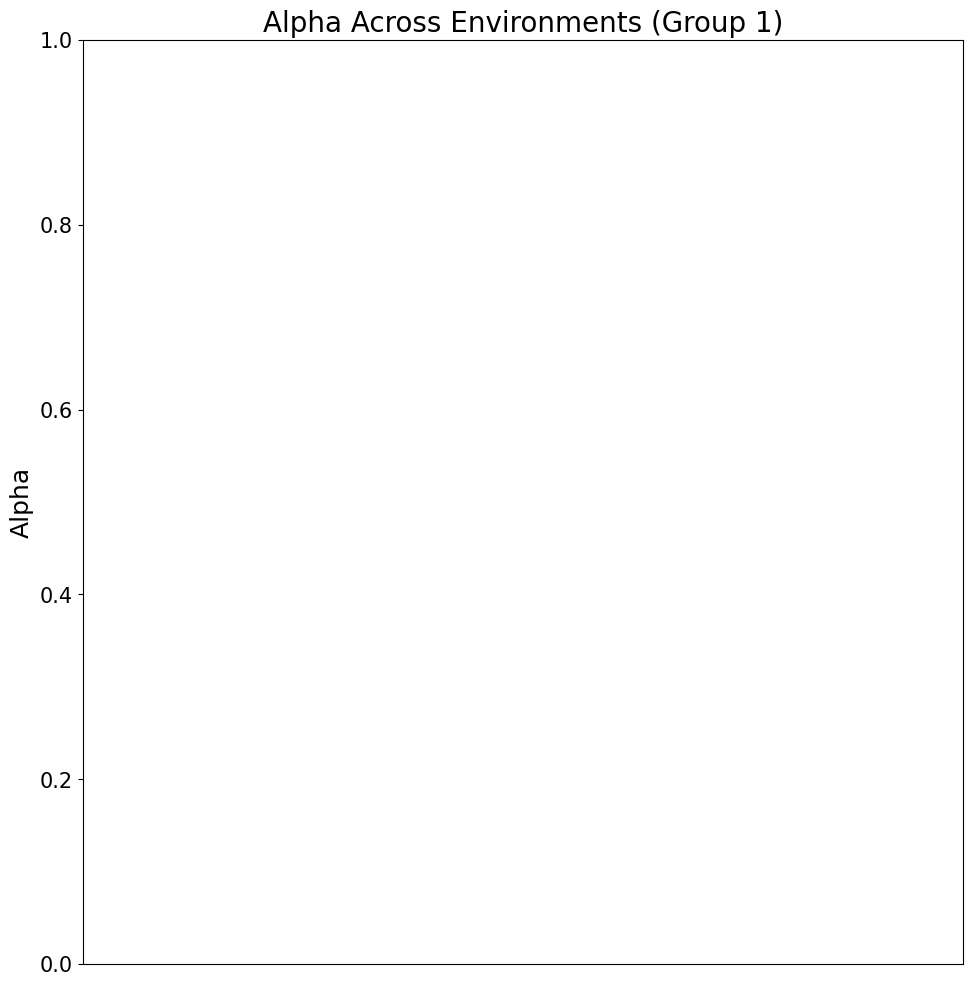

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import seaborn as sns

# Combine data across all files into a single dictionary grouped by environment
combined_params = {'alpha': {}, 'beta': {}, 'tau': {},  'gamma': {}}
for file_data in all_RL_params.values():
    for environment, params in file_data.items():
        for param_name, param_value in params.items():
            if param_name not in combined_params:
                continue  # Skip keys that are not in combined_params
            if environment not in combined_params[param_name]:
                combined_params[param_name][environment] = []
            combined_params[param_name][environment].append(param_value)

# Function to perform Wilcoxon test and return significance stars
def get_significance_stars(data1, data2):
    try:
        # Filter out NaN values from both data1 and data2
        valid_data1 = np.array(data1)
        valid_data2 = np.array(data2)                                                                          
        
        # Ensure paired tests by ignoring animals where either data1 or data2 is NaN
        paired_indices = ~np.isnan(data1) & ~np.isnan(data2)
        valid_data1 = np.array(data1)[paired_indices]
        valid_data2 = np.array(data2)[paired_indices]
        
        stat, p = wilcoxon(valid_data1, valid_data2)
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'  # Not significant
    except ValueError:
        return 'ns'  # Handle cases where Wilcoxon cannot be computed

def plot_boxplots_with_stats(parameter_name, data_dict, env_subset, subplot_index, total_subplots):
    env_names = env_subset
    data = [data_dict[env] for env in env_names]

    plt.subplot(1,total_subplots, subplot_index)
    sns.boxplot(data=data, notch=True)
    sns.swarmplot(data=data, color=".25", size=5)
    plt.xticks(range(len(env_names)), env_names)
    plt.ylabel(parameter_name)
    plt.title(f'{parameter_name} Across Environments (Group {subplot_index})')

    # Connect dots with lines
    # Ensure paired data by filtering out NaN values
    paired_data = np.array([data_dict[env] for env in env_names]).T  # Transpose to group by individual
    for individual_data in paired_data:
        valid_indices = ~np.isnan(individual_data)  # Ignore NaN values
        plt.plot(np.arange(len(env_names))[valid_indices], individual_data[valid_indices], color='gray', alpha=0.1)


    # Add significance stars
    max_y = max([max(d) for d in data if len(d) > 0]) + 0.1  # Initial height for stars
    spacing = 0.2  # Spacing between significance lines

    for i in range(len(env_names)):
        for j in range(i + 1, len(env_names)):
            data1 = data[i]
            data2 = data[j]
            stars = get_significance_stars(data1, data2)
            if stars != 'ns':  # Only plot stars for significant results
                y_max = max_y  # Use the current max_y for plotting
                plt.plot([i, j], [y_max, y_max], color='black', linewidth=1)
                plt.text((i + j) / 2, y_max + 0.02, stars, ha='center', fontsize=12)
                max_y += spacing  # Increment max_y for subsequent stars

# Plot and compare parameters
for param_name, param_data in combined_params.items():
    plt.figure(figsize=(25, 12))  # Adjust figure size for multiple subplots

    # First subplot for the first 4 environments
    first_envs = list(param_data.keys())[:4]
    plot_boxplots_with_stats(param_name.capitalize(), param_data, first_envs, subplot_index=1, total_subplots=2)

    # Second subplot for the second 4 environments
    second_envs = list(param_data.keys())[4:]
    plot_boxplots_with_stats(param_name.capitalize(), param_data, second_envs, subplot_index=2, total_subplots=2)

    plt.tight_layout()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import log, sqrt

# Extract environments and their alpha-beta values
env_names = list(combined_params['alpha'].keys())

# Calculate color values based only on the first environment
first_env = env_names[4]
first_alphas = np.array(combined_params['alpha'][first_env])
first_betas = np.array(combined_params['beta'][first_env])
color_values = (1 - first_alphas) * first_betas 

# Normalize color values globally
global_color_min, global_color_max = min(color_values), max(color_values)
normalized_colors = sqrt((color_values - global_color_min) / (global_color_max - global_color_min))

# Shared limits for alpha and beta
global_alpha_min, global_alpha_max = 0, 1
global_beta_min, global_beta_max = 0, 5

# Create the original figure with subplots
plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization

for i, environment in enumerate(env_names):
    alphas = np.array(combined_params['alpha'][environment])
    betas = np.array(combined_params['beta'][environment])
    
    # Create a subplot for each environment
    plt.subplot(2, len(env_names) // 2, i + 1)  # Arrange subplots in a grid
    valid_indices = ~np.isnan(alphas) & ~np.isnan(betas)
    paired_alphas = alphas[valid_indices]
    paired_betas = betas[valid_indices]
    paired_colors = normalized_colors[valid_indices]

    scatter = plt.scatter(paired_alphas, paired_betas, c=paired_colors, cmap='jet', alpha=0.8)
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'{environment}')
    plt.grid(True)
    plt.xlim(global_alpha_min, global_alpha_max)
    plt.ylim(global_beta_min, global_beta_max)

# Add a single colorbar for all subplots
plt.tight_layout()
plt.show()

# Create a figure for the first four environments
plt.figure(figsize=(10, 6))

# Define colors for environments
colors = ['red', 'blue', 'green', 'orange']

# Plot first four environments
for i, environment in enumerate(env_names[0:4]):
    alphas = np.array(combined_params['alpha'][environment])
    betas = np.array(combined_params['beta'][environment])
    valid_indices = ~np.isnan(alphas) & ~np.isnan(betas)
    paired_alphas = alphas[valid_indices]
    paired_betas = betas[valid_indices]
    plt.scatter(paired_alphas, paired_betas, color=colors[i], label=environment, alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Combined Scatter Plot of First Four Environments')
plt.legend(title='Environment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xlim(global_alpha_min, global_alpha_max)
plt.ylim(global_beta_min, global_beta_max)

# Show the first plot
plt.tight_layout()
plt.show()

# Create a figure for the second four environments
plt.figure(figsize=(10, 6))

# Define colors for environments
colors = ['magenta','purple', 'teal', 'pink']

# Plot second four environments
for i, environment in enumerate([env_names[4],env_names[5], env_names[6], env_names[7]]):  # Adjusted indices to valid range
    alphas = np.array(combined_params['alpha'][environment])
    betas = np.array(combined_params['beta'][environment])
    valid_indices = ~np.isnan(alphas) & ~np.isnan(betas)
    paired_alphas = alphas[valid_indices]
    paired_betas = betas[valid_indices]
    plt.scatter(paired_alphas, paired_betas, color=colors[i], label=environment, alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Combined Scatter Plot of Second Four Environments')
plt.legend(title='Environment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xlim(global_alpha_min, global_alpha_max)
plt.ylim(global_beta_min, global_beta_max)

# Show the second plot
plt.tight_layout()
plt.show()

IndexError: list index out of range

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract environments and their alpha-beta values
env_names = list(combined_params['alpha'].keys())

# Calculate global limits for alpha and beta
all_alphas = [value for env in combined_params['alpha'].values() for value in env]
all_betas = [value for env in combined_params['beta'].values() for value in env]
global_alpha_min, global_alpha_max = min(all_alphas), max(all_alphas)
global_beta_min, global_beta_max = min(all_betas), max(all_betas)

# Extract collected rewards from all_params for normalization
all_rewards = [params['collected_rewards'] for params in all_params.values() if 'collected_rewards' in params]

plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization

# Loop through environments and create scatter plots
for i, environment in enumerate(env_names):
    alphas = np.array(combined_params['alpha'][environment])
    betas = np.array(combined_params['beta'][environment])
    
    # Initialize rewards as a numpy array to store reward values for each animal
    rewards = np.full(len(all_params), np.nan)  # Default to NaN for animals with no sessions
    
    for animal_index, animal in enumerate(all_params.keys()):
        sesinx = all_params[animal][environment]
        rewards[animal_index] = np.mean(all_rewards[animal_index][sesinx]) if len(sesinx) > 0 else np.nan

    # Ensure paired colors by filtering out NaN values in alphas, betas, and rewards
    valid_indices = ~np.isnan(alphas) & ~np.isnan(betas)
    paired_alphas = alphas[valid_indices]
    paired_betas = betas[valid_indices]
    paired_rewards = rewards[valid_indices]

    # Create a subplot for each environment
    plt.subplot(2, len(env_names) // 2, i + 1)  # Arrange subplots in a grid
    scatter = plt.scatter(paired_alphas, paired_betas, c=paired_rewards, cmap='jet', alpha=0.8, vmin = 0.5, vmax = 0.85)
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title(f'{environment}')
    plt.grid(True)
    
    # Set shared x and y limits
    plt.xlim(global_alpha_min, global_alpha_max)
    plt.ylim(global_beta_min, global_beta_max)

# Add a single colorbar for all subplots
plt.subplots_adjust(right=0.85)  # Adjust layout to make space for the colorbar
cbar_ax = plt.gcf().add_axes([1, 0.15, 0.02, 0.77])  # Position for the colorbar
cbar = plt.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Collected Rewards')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

ValueError: min() arg is an empty sequence

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extract environments and their alpha-beta values
env_volatility_controlled = 'env_volatility_controled'
env_extremity_controlled = 'env_extremity_controled'

alphas_volatility = np.array(combined_params['alpha'][env_volatility_controlled])
betas_volatility = np.array(combined_params['beta'][env_volatility_controlled])
alphas_extremity = np.array(combined_params['alpha'][env_extremity_controlled])
betas_extremity = np.array(combined_params['beta'][env_extremity_controlled])

# Extract collected rewards from all_params for normalization
all_rewards = [params['likelyside_picks'] for params in all_params.values() if 'likelyside_picks' in params]

# Extract rewards for the two environments
rewards_volatility = np.array([np.mean(all_rewards[animal_index][all_params[animal][env_volatility_controlled]]) 
                                if len(all_params[animal][env_volatility_controlled]) > 0 else np.nan 
                                for animal_index, animal in enumerate(all_params.keys())])

rewards_extremity = np.array([np.mean(all_rewards[animal_index][all_params[animal][env_extremity_controlled]]) 
                              if len(all_params[animal][env_extremity_controlled]) > 0 else np.nan 
                              for animal_index, animal in enumerate(all_params.keys())])

# Calculate the mean rewards across the two environments
mean_rewards = np.nanmean([rewards_volatility, rewards_extremity], axis=0)

# Ensure paired data by filtering out NaN values
valid_indices = ~np.isnan(alphas_volatility) & ~np.isnan(betas_volatility) & ~np.isnan(alphas_extremity) & ~np.isnan(betas_extremity)
paired_alphas_volatility = alphas_volatility[valid_indices]
paired_betas_volatility = betas_volatility[valid_indices]
paired_alphas_extremity = alphas_extremity[valid_indices]
paired_betas_extremity = betas_extremity[valid_indices]
paired_rewards_volatility = rewards_volatility[valid_indices]
paired_rewards_extremity = rewards_extremity[valid_indices]
paired_mean_rewards = mean_rewards[valid_indices]

# Calculate differences
alpha_diff = paired_alphas_volatility - paired_alphas_extremity
beta_diff = paired_betas_volatility - paired_betas_extremity

# Plot 1: Color coded by rewards in volatility controlled
plt.figure(figsize=(8, 6))
scatter = plt.scatter(alpha_diff, beta_diff, c=paired_rewards_volatility, cmap='plasma', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add vertical line at x=0
plt.xlabel('Alpha Difference (Volatility - Extremity)')
plt.ylabel('Beta Difference (Volatility - Extremity)')
plt.title('Beta vs Alpha Difference (Colored by Volatility Rewards)')
plt.colorbar(scatter, label='Volatility Controlled Rewards')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Color coded by rewards in extremity controlled
plt.figure(figsize=(8, 6))
scatter = plt.scatter(alpha_diff, beta_diff, c=paired_rewards_extremity, cmap='plasma', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add vertical line at x=0
plt.xlabel('Alpha Difference (Volatility - Extremity)')
plt.ylabel('Beta Difference (Volatility - Extremity)')
plt.title('Beta vs Alpha Difference (Colored by Extremity Rewards)')
plt.colorbar(scatter, label='Extremity Controlled Rewards')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Color coded by mean rewards across both environments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(alpha_diff, beta_diff, c=paired_mean_rewards, cmap='plasma', alpha=0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add vertical line at x=0
plt.xlabel('Alpha Difference (Volatility - Extremity)')
plt.ylabel('Beta Difference (Volatility - Extremity)')
plt.title('Beta vs Alpha Difference (Colored by Mean Rewards)')
plt.colorbar(scatter, label='Mean Rewards')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'env_volatility_controled'

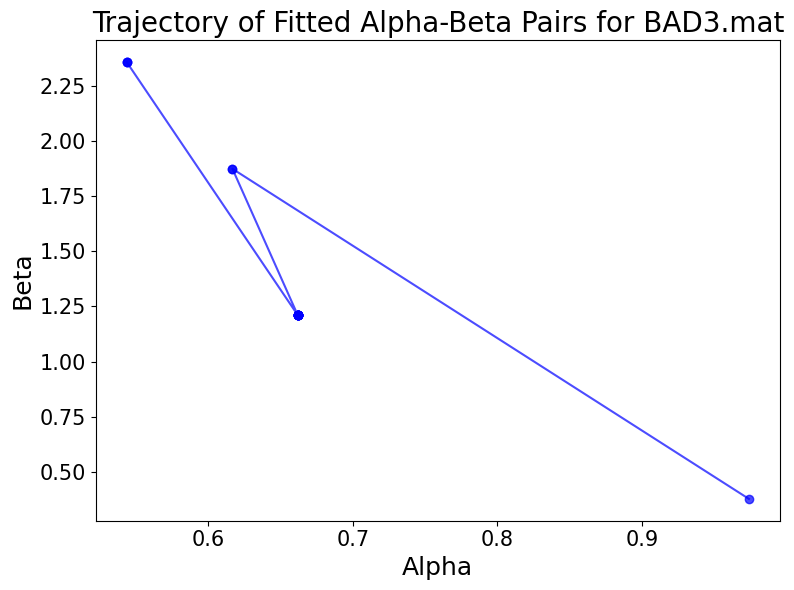

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first mouse
first_mouse = list(all_params.keys())[0]  # Get the first mouse's key
mouse_sessions = all_params[first_mouse]  # Extract session data for the first mouse

# Extract fitted alpha-beta pairs for each session
alpha_values = []
beta_values = []

for env_name, session_indices in mouse_sessions.items():
    if env_name in ['env_pretraining', 'env_baseline', 'env_volatility_controled', 'env_extremity_controled']:
        for session_index in session_indices:
            # Extract fitted alpha and beta values for the session
            fitted_alpha = all_RL_params[first_mouse][env_name]['alpha']
            fitted_beta = all_RL_params[first_mouse][env_name]['beta']
            alpha_values.append(fitted_alpha)
            beta_values.append(fitted_beta)

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, beta_values, marker='o', linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title(f'Trajectory of Fitted Alpha-Beta Pairs for {first_mouse}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import scipy.io  # For saving to .mat files
import glob  # For finding all files in a directory

LOCAL_PATH = folder_path  #@param
use_gamma = False  #@param {type:"boolean"}
use_tau = True  #@param {type:"boolean"}

importlib.reload(bandits)
importlib.reload(rnn_utils)

refit = False  #@param {type:"boolean"}

# Get all .mat files in the LOCAL_PATH directory
all_files = glob.glob(os.path.join(LOCAL_PATH, "*.mat"))

def get_environment_for_session(all_params, animal, session_index):
        # Get the first four environments for the specified animal
        envlist = ['env_pretraining', 'env_predictable', 'env_slowly_changing', 'env_fast_changing','env_unpredictable']
        
        # Iterate through the first four environments
        for env_name in envlist:
            if session_index in all_params[animal][env_name]:
                return env_name  # Return the environment name if the session index is found
        
        return None  # Return None if the session index is not found in the first four environments


def new_func(session, probs):
    # Clip probabilities to [0, 1] range
    probs_clipped = np.clip(probs[:, session], 0, 1)
    probs_combined = np.vstack((1 - probs_clipped, probs_clipped)).T
    return probs_combined

for file_path in all_files:

    # Initialize a dictionary to store activations for all sessions
    all_rl_activations = {}
    VALUE_list = []
    ENVIRONMENT_list = []
    PARAMTERS_MATRIX = []

    # Extract the directory and animal name from the input file path
    data_dir = os.path.dirname(file_path)  # Directory where the data is located
    animal_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract animal name (e.g., "BAD16")

    # Load and format the dataset for the current file
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(file_path, '.')[:2], rnn_utils.DatasetRNN)

    # Extract data for the current session
    for session in range(dataset_train._xs.shape[1]):
        print(f"Processing session {session + 1}/{dataset_train._xs.shape[1]} for {animal_name}")
        # Extract data for the current session
        xs_session = dataset_train._xs[:, session, :]
        ys_session = dataset_train._ys[:, session, :]
        xs_session = xs_session.reshape(xs_session.shape[0], 1, xs_session.shape[1])
        ys_session = ys_session.reshape(ys_session.shape[0], 1, ys_session.shape[1])
        
        trial_end = rnn_utils.find_session_end(xs_session[:, :, 0].squeeze())
        xs_session = xs_session[:trial_end, :,:]
        ys_session = ys_session[:trial_end, :,:]

        Mdata = loadmat(os.path.join('.',file_path))
        probs = Mdata['PROBS']
        probs_combined = new_func(session, probs)

        # Create a dataset for the current session
        dataset_session = rnn_utils.DatasetRNN(xs_session, ys_session)
        animal = f"{animal_name}.mat"  # Concatenate animal_name with '.mat'
        env = get_environment_for_session(all_params, animal, session)

         
        if refit:
            # Fit the model for the current session with bounds on beta
            rl_params, loss, converged = rnn_utils.fit_model(
                model_fun=bandits.HkAgentQ,
                dataset=dataset_session,
                loss_fun='categorical',
                optimizer=optax.adam(1e-1),
                convergence_thresh=1e-5,
                n_steps_per_call=100,
                n_steps_max=5000,
                use_gamma=use_gamma,
                use_tau=use_tau,
                parameter_bounds={'beta': (0.0, 6.0), 'tau': (0.0, 2.0)},  # Constrained bounds
            )
        else:
            # Use precomputed RL parameters for the session
            if animal_name not in all_RL_params or session not in all_RL_params[animal_name]:
                print(f"Warning: No RL parameters found for {animal_name} in session {session}. Skipping...")
                continue
            rl_params = all_RL_params[animal][env]
        
            # Use the RL parameters directly without fitting
            alpha = rl_params['alpha']
            beta = rl_params['beta']
            gamma = rl_params.get('gamma', np.nan)  # Default to np.nan if gamma is not used
            tau = rl_params.get('tau', np.nan)  # Default to np.nan if tau is not used

            # Create a dictionary to store the RL parameters
            rl_params = {
                'hk_agent_q': {
                'alpha_unsigmoid': np.array([jax.scipy.special.logit(alpha)], dtype=np.float32),
                'beta': np.array([beta], dtype=np.float32), 
                'gamma_unsigmoid': np.array([jax.scipy.special.logit(gamma)], dtype=np.float32) if use_gamma else None,
                'tau': np.array([tau], dtype=np.float32) if use_tau else None
                }
            }
        # Evaluate the model with the RL parameters
        network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs_session)
        network_states = np.array(network_states)

        choices = xs_session[:trial_end, :, 0].squeeze()
        rewards = xs_session[:trial_end, :, 1].squeeze()
        rl_activations = network_states[:, :, :].squeeze()

        # Append the activations for the current session to the list
        VALUE_list.append(rl_activations)  # Store each session as a separate array
        ENVIRONMENT_list.append(env)  # Store each session as a separate array
    
        # Create a matrix to store parameters: columns are [alpha, beta, gamma, tau]
        param_row = np.full((1, 5), np.nan, dtype=np.float32)
        param_row[0, 0] = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
        param_row[0, 1] = rl_params['hk_agent_q']['beta'][0]
        if use_gamma:
            param_row[0, 2] = jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0])
        if use_tau:
            param_row[0, 3] = rl_params['hk_agent_q']['tau'][0]
        param_row[0, 4] = converged if refit else 1  # 1 if converged or if not refitting, else 0   
        # Append to PARAMTERS_MATRIX
        PARAMTERS_MATRIX.append(param_row)

        import matplotlib.pyplot as plt

        # Create a folder for each animal inside the VALUES directory
        animal_dir = os.path.join(data_dir, animal_name)
        os.makedirs(animal_dir, exist_ok=True)

        # Plot the session as before
        ax = bandits.plot_session(
            choices=choices, rewards=rewards, timeseries=rl_activations,
            timeseries_name="Fit Model's Q-Values",
            timeseriesb=probs_combined[0:trial_end, :],
            labels=[f'Q({"↓" if a == 0 else "↑"})' for a in range(2)]
        )
        fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
        fit_beta = rl_params['hk_agent_q']['beta'][0]
        fit_gamma = 0
        fit_tau = 0
        if use_gamma:
            fit_gamma = jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0])
        if use_tau:
            fit_tau = rl_params['hk_agent_q']['tau'][0]

        parameter_text = (
            f"α = {fit_alpha:.2f} \n"
            f"β = {fit_beta:.2f} \n"
            f"γ = {fit_gamma:.2f} \n"
            f"τ = {fit_tau:.2f}"
        )
        # Place the textbox inside the axes, top right corner
        ax.text(
            1.1, 0.2, parameter_text, ha='right', va='top', fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
        )

        # Save the figure as PNG in the animal's folder
        fig = ax.figure
        # Save as PNG
        fig.savefig(os.path.join(animal_dir, f"{animal_name}_session{session}_plot.png"))
        # Save as vector PDF
        fig.savefig(os.path.join(animal_dir, f"{animal_name}_session{session}_plot.pdf"), format='pdf')
        plt.close(fig)
    
    # Add SESSIONIDs to the dictionary
    if 'SESSIONIDs' in Mdata:
        all_rl_activations['SESSIONIDs'] = Mdata['SESSIONIDs']
    else:
        print(f"Warning: 'SESSIONIDs' key not found in Mdata for file {file_path}. Skipping...")
        all_rl_activations['SESSIONIDs'] = None  # Or provide a default value if necessary
    all_rl_activations['VALUE'] = VALUE_list  # Store the big matrix
    all_rl_activations['ENVIRONMENT'] = ENVIRONMENT_list  # Store the environment list
    all_rl_activations['PARAMETERS'] =  PARAMTERS_MATRIX # Store the parameters for the session
    values_dir = os.path.join(data_dir, "VALUES")
    os.makedirs(values_dir, exist_ok=True)  # Create the folder if it doesn't exist

    # Save the activations to a .mat file in the "VALUES" folder
    output_file = os.path.join(values_dir, f"{animal_name}_values.mat")
    scipy.io.savemat(output_file, all_rl_activations)


    

NameError: name 'folder_path' is not defined

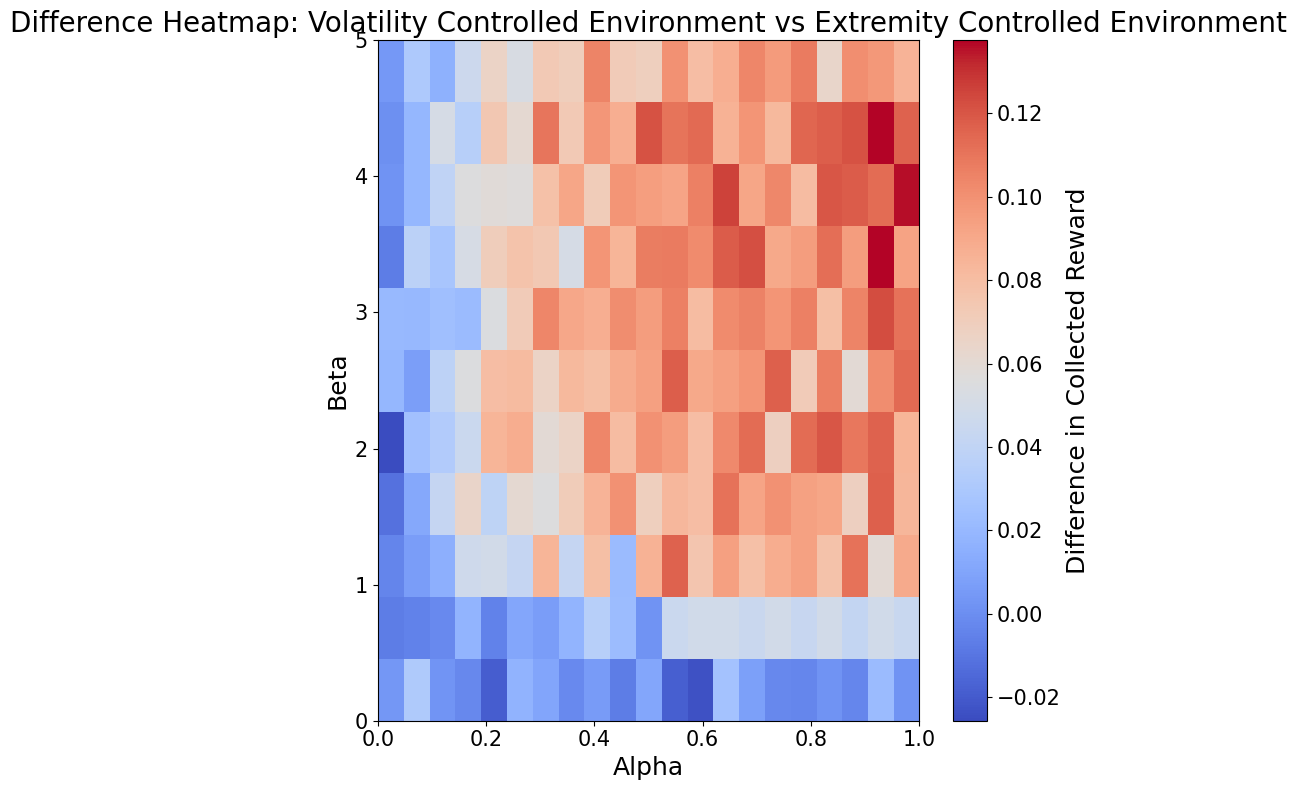

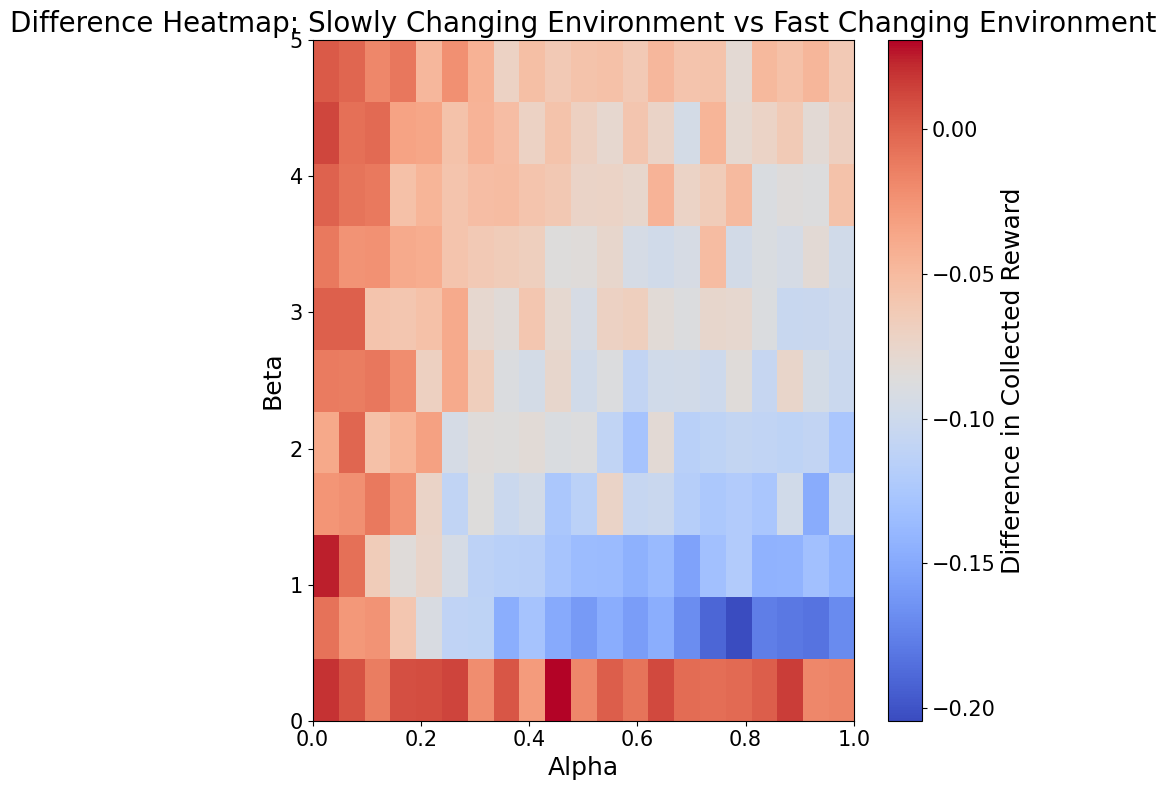

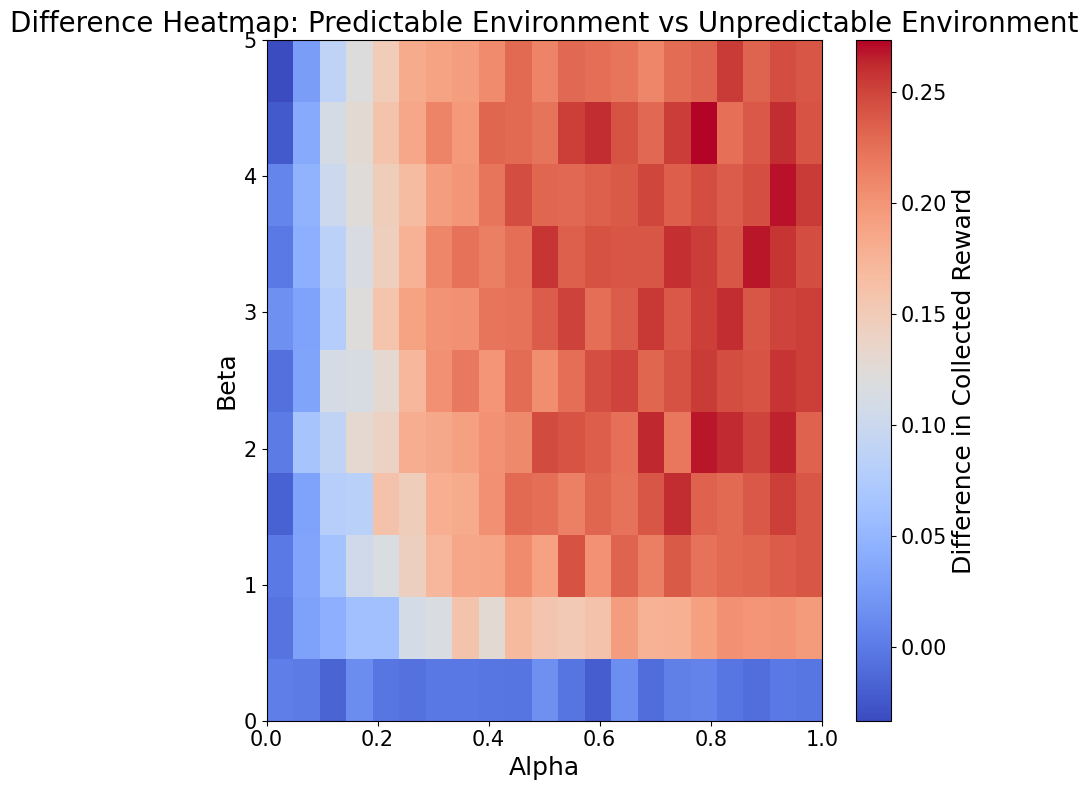

In [184]:
# Loop through each figure and environment pair
for fig_idx, (env1, env2) in enumerate(env_pairs):
       fig, axes = figures[fig_idx]

       # Calculate the difference map
       difference_map = reward_matrix[:, :, env1] - reward_matrix[:, :, env2]

       # Create a new figure for the difference heatmap
       fig_diff, ax_diff = plt.subplots(figsize=(8, 8))
       im = ax_diff.imshow(difference_map, extent=(alpha_range[0], alpha_range[-1], beta_range[0], beta_range[-1]), origin='lower', cmap='coolwarm', aspect='auto')
       cbar = fig_diff.colorbar(im, ax=ax_diff, label='Difference in Collected Reward')
       ax_diff.set_xlabel('Alpha')
       ax_diff.set_ylabel('Beta')
       ax_diff.set_title(f'Difference Heatmap: {titles[fig_idx][0]} vs {titles[fig_idx][1]}')
       ax_diff.grid(True)
       plt.tight_layout()
       plt.show()


In [ ]:
#@title Run some diagnostics to characterize the dataset

experiment_list_to_view = {
	'choices': dataset_test._xs[:, :, 0],
	'rewards': dataset_test._xs[:, :, 1],
    'timeseries': dataset_test._xs[:, :, 2],
}
bandits.show_valuemetric(experiment_list_to_view)
plt.figure()
plotting.plot_action_similarity_to_history(experiment_list_to_view, n_steps_back=100)